## Import Library

In [ ]:
!pip install gdown

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import pickle
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.neighbors import KDTree
from joblib import Parallel, delayed

## Import Pre-processed Data

In [ ]:
!mkdir -p content/data
# Download all files
file_ids = [
    '1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq',  # X_train
    '1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1',  # X_train_resampled
    '1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR',  # X_test
    '1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ',  # X_test_resampled
    '1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z',  # Y_train
    '1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf',  # Y_train_resampled
    '1-CUpVhcZ6-Qop7R9Z6Btb2gEf7f0XgGy'   # Y_test
]

file_paths = [
    'content/data/X_train.pkl',
    'content/data/X_train_resampled.pkl',
    'content/data/X_test.pkl',
    'content/data/X_test_resampled.pkl',
    'content/data/Y_train.pkl',
    'content/data/Y_train_resampled.pkl',
    'content/data/Y_test.pkl'
]
for file_id, file_path in zip(file_ids, file_paths):
    gdown.download(f'https://drive.google.com/uc?id={file_id}', file_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1fdbbwFuXm0zrXYi3i9MvCqilA9i7OcZq
To: /content/content/data/X_train.pkl
100%|██████████| 21.4M/21.4M [00:01<00:00, 21.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1iUTztO9XpxwzF02JhoW3pdMs5jKrw1
To: /content/content/data/X_train_resampled.pkl
100%|██████████| 18.7M/18.7M [00:00<00:00, 68.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-39uqbcZldsGLgDKYfxIHsSNGewMXJRR
To: /content/content/data/X_test.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 67.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Ms25aS5NADPDYdt8AGAUyYIjbdBvKGFZ
To: /content/content/data/X_test_resampled.pkl
100%|██████████| 5.35M/5.35M [00:00<00:00, 33.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-CChPe58Z6E-H6EXIzKsgUhqbITAd54z
To: /content/content/data/Y_train.pkl
100%|██████████| 2.79M/2.79M [00:00<00:00, 35.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1D3wYlWZbt5NeM59QTA1JaVVvnaAZzFUf
To: /conten

In [ ]:
# Không dùng đến các cột _scaled, mà sẽ đi chuẩn hóa ở phía dưới
X_train = pd.read_pickle('content/data/X_train.pkl')
X_train_resampled = pd.read_pickle('content/data/X_train_resampled.pkl')
X_test = pd.read_pickle('content/data/X_test.pkl')
X_test_resampled = pd.read_pickle('content/data/X_test_resampled.pkl')
y_train = pd.read_pickle('content/data/Y_train.pkl')
y_train_resampled = pd.read_pickle('content/data/Y_train_resampled.pkl')
y_test = pd.read_pickle('content/data/Y_test.pkl')

In [ ]:
import time
pred_time=[]

In [ ]:
result_acc = []
result_recall = []

## 1. KNN - Thư viện

### 1.1 No resampled

In [ ]:
param_grid_n_neighbors = {'n_neighbors': [5, 10, 15, 20, 30, 50, 70, 100]}
metrics = ['euclidean', 'manhattan', 'chebyshev']
results = {}

for metric in metrics:
    grid_search = GridSearchCV(KNeighborsClassifier(weights='distance', metric=metric),
                               param_grid_n_neighbors, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    results[metric] = {
        'mean_accuracy': grid_search.cv_results_['mean_test_score'],
        'std_accuracy': grid_search.cv_results_['std_test_score']
    }

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


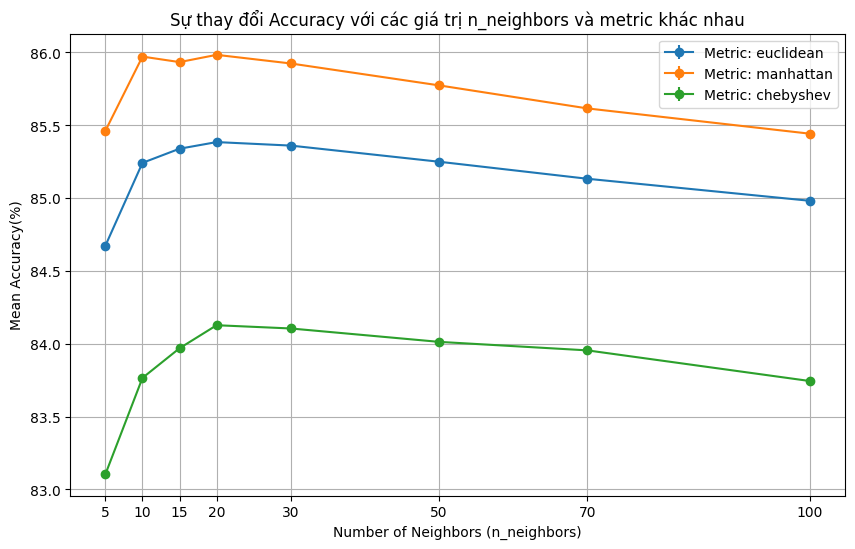

In [ ]:
plt.figure(figsize=(10, 6))

for metric in metrics:
    mean_acc = results[metric]['mean_accuracy']*100
    std_acc = results[metric]['std_accuracy']
    plt.errorbar(param_grid_n_neighbors['n_neighbors'], mean_acc, yerr=std_acc, label=f"Metric: {metric}", fmt='o-')
plt.xticks(param_grid_n_neighbors['n_neighbors'], labels=[str(n) for n in param_grid_n_neighbors['n_neighbors']])
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Mean Accuracy(%)")
plt.title("Sự thay đổi Accuracy với các giá trị n_neighbors và metric khác nhau")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Xây dựng KNN với giá trị k tốt nhất vừa tìm được
knn=KNeighborsClassifier(metric='manhattan', n_neighbors=10, weights='distance')
knn.fit(X_train,y_train)

# Dự đoán trên tập Test
start_time = time.time()
y_pred = knn.predict(X_test)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc = accuracy_score(y_test, y_pred) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")

Time to predict: 99.5432 seconds
Accuracy on Test set: 86.35%


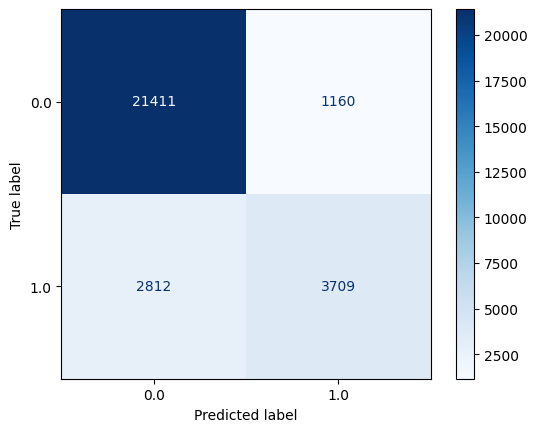

<Figure size 1200x1200 with 0 Axes>

In [ ]:
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap='Blues')
plt.figure(figsize=(12, 12))
plt.show();

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92     22571
         1.0       0.76      0.57      0.65      6521

    accuracy                           0.86     29092
   macro avg       0.82      0.76      0.78     29092
weighted avg       0.86      0.86      0.86     29092



In [ ]:
recall = recall_score(y_test, y_pred, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall[0])
result_recall.append(recall)

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.568777794816746
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.9486066191130211


### 1.2 Resampled

In [ ]:
param_grid_n_neighbors = {'n_neighbors': [5, 10, 15, 20, 30, 50, 70, 100]}
metrics = ['euclidean', 'manhattan', 'chebyshev']
results = {}

for metric in metrics:
    grid_search = GridSearchCV(KNeighborsClassifier(weights='distance', metric=metric),
                               param_grid_n_neighbors, cv=3, verbose=1, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_resampled, y_train_resampled)
    results[metric] = {
        'mean_accuracy': grid_search.cv_results_['mean_test_score'],
        'std_accuracy': grid_search.cv_results_['std_test_score']
    }

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


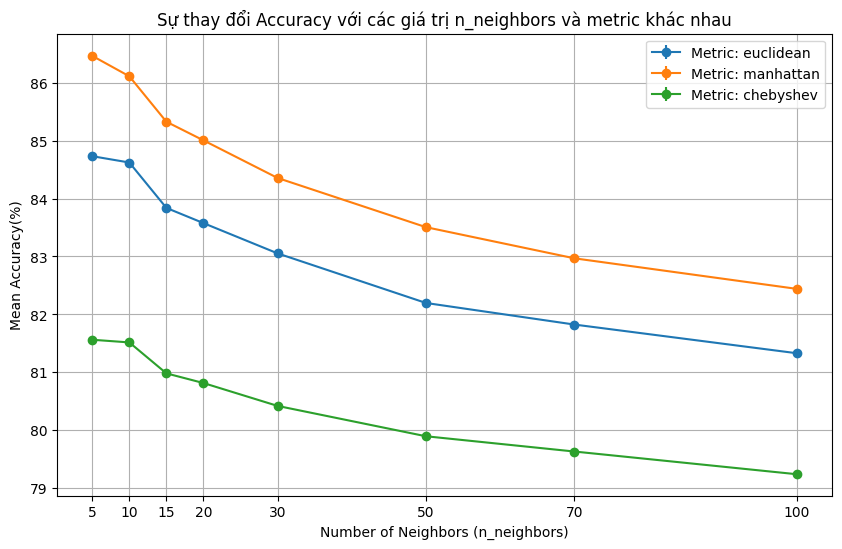

In [ ]:
plt.figure(figsize=(10, 6))

for metric in metrics:
    mean_acc = results[metric]['mean_accuracy']*100
    std_acc = results[metric]['std_accuracy']
    plt.errorbar(param_grid_n_neighbors['n_neighbors'], mean_acc, yerr=std_acc, label=f"Metric: {metric}", fmt='o-')
plt.xticks(param_grid_n_neighbors['n_neighbors'], labels=[str(n) for n in param_grid_n_neighbors['n_neighbors']])
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Mean Accuracy(%)")
plt.title("Sự thay đổi Accuracy với các giá trị n_neighbors và metric khác nhau")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Xây dựng KNN với giá trị k tốt nhất tìm được
knn_res=KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')
knn_res.fit(X_train_resampled,y_train_resampled)

# Dự đoán trên tập Test
start_time = time.time()
y_pred_res = knn_res.predict(X_test_resampled)
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")
acc = accuracy_score(y_test, y_pred_res) * 100
result_acc.append(acc)
print(f"Accuracy on Test set: {acc:.2f}%")

Time to predict: 92.7509 seconds
Accuracy on Test set: 82.13%


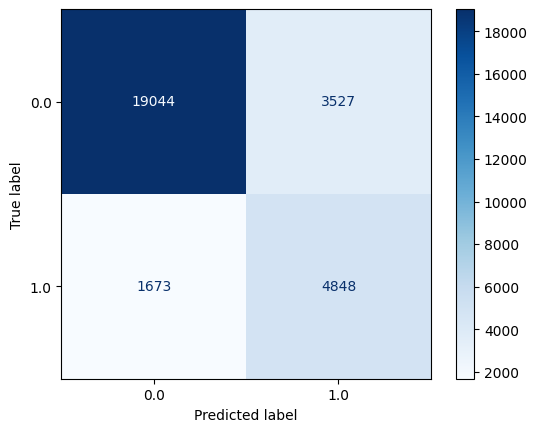

<Figure size 1200x1200 with 0 Axes>

In [ ]:
ConfusionMatrixDisplay.from_estimator(knn_res, X_test_resampled, y_test, cmap='Blues')
plt.figure(figsize=(12, 12))
plt.show();

In [ ]:
print(classification_report(y_test, y_pred_res))

              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88     22571
         1.0       0.58      0.74      0.65      6521

    accuracy                           0.82     29092
   macro avg       0.75      0.79      0.77     29092
weighted avg       0.84      0.82      0.83     29092



In [ ]:
recall = recall_score(y_test, y_pred_res, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall[0])
result_recall.append(recall)

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.7434442570157951
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.8437375393203669


## 2. KNN - Tự code

### 2.1 No resampled

In [ ]:
# Vẫn phải bổ sung thư viện hỗ trợ như KDTree hay Parallel, vì quá trình tính toán thông thường quá lâu
class KNN:
    def __init__(self, top_k=15):
        self.top_k = top_k
        self.X_train = None
        self.y_train = None
        self.tree = None  # KDTree for efficient searching

    def fit(self, X, y):
        """Xây dựng KDTree từ dữ liệu huấn luyện"""
        self.X_train = X
        self.y_train = y
        self.tree = KDTree(X)  # Build KDTree from training data

    def predict(self, x):
        """Dự đoán nhãn cho một điểm dữ liệu x"""
        # Sử dụng KDTree để tìm các điểm gần nhất
        dist, indices = self.tree.query([x], k=self.top_k)

        # Lấy nhãn của k điểm gần nhất
        k_nearests = self.y_train[indices[0]]

        # Dự đoán nhãn dựa trên phương pháp majority vote
        label = Counter(k_nearests).most_common(1)[0][0]
        return label

    def predict_batch(self, X):
        """Dự đoán cho một tập các điểm dữ liệu (batch)"""
        # Sử dụng joblib Parallel để chạy song song
        y_pred = Parallel(n_jobs=-1)(delayed(self.predict)(x) for x in X)
        return y_pred

In [ ]:
knn_by_hand=KNN(top_k=15)
knn_by_hand.fit(np.array(X_train), np.array(y_train))

# Dự đoán trên tập Test
start_time = time.time()
y_pred_by_hand = knn_by_hand.predict_batch(np.array(X_test))
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")

acc = accuracy_score(y_pred_by_hand, np.array(y_test))*100
result_acc.append(acc)
print("Test Accuracy {:.2f}%".format(acc))


Time to predict: 175.2599 seconds
Test Accuracy 85.57%


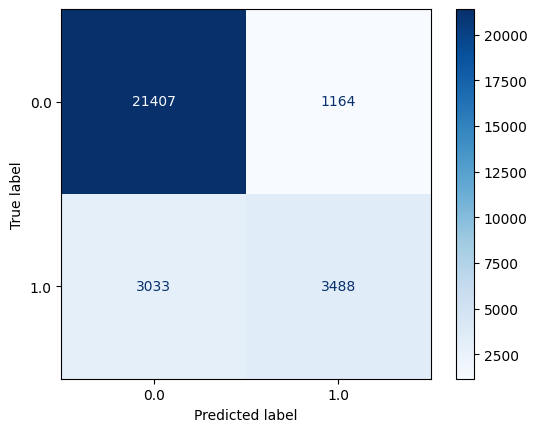

<Figure size 1200x1200 with 0 Axes>

In [ ]:
cm=confusion_matrix(y_test, y_pred_by_hand)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_by_hand))

              precision    recall  f1-score   support

         0.0       0.88      0.95      0.91     22571
         1.0       0.75      0.53      0.62      6521

    accuracy                           0.86     29092
   macro avg       0.81      0.74      0.77     29092
weighted avg       0.85      0.86      0.85     29092



In [ ]:
recall = recall_score(y_test, y_pred_by_hand, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall[0])

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.5348872872258856
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.9484294005582384


### 2.2 Resampled

In [ ]:
knn_by_hand=KNN(top_k=15)
knn_by_hand.fit(np.array(X_train_resampled), np.array(y_train_resampled))

# Dự đoán trên tập Test
start_time = time.time()
y_pred_by_hand = knn_by_hand.predict_batch(np.array(X_test_resampled))
end_time = time.time()
predict_time=end_time-start_time
pred_time.append(predict_time)
print(f"Time to predict: {predict_time:.4f} seconds")

acc = accuracy_score(y_pred_by_hand, np.array(y_test))*100
result_acc.append(acc)
print("Test Accuracy {:.2f}%".format(acc))

Time to predict: 150.8175 seconds
Test Accuracy 80.93%


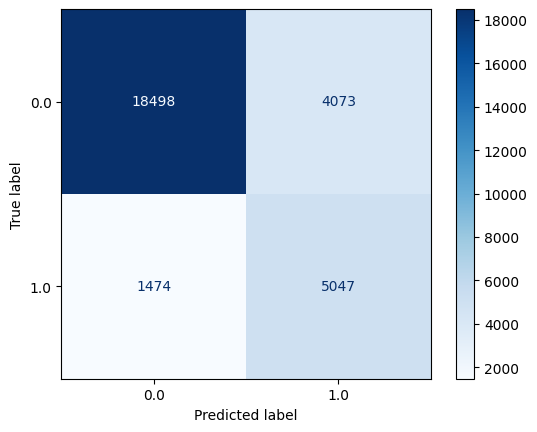

<Figure size 1200x1200 with 0 Axes>

In [ ]:
cm=confusion_matrix(y_test, y_pred_by_hand)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap='Blues', values_format='d')
plt.figure(figsize=(12, 12))
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_by_hand))

              precision    recall  f1-score   support

         0.0       0.93      0.82      0.87     22571
         1.0       0.55      0.77      0.65      6521

    accuracy                           0.81     29092
   macro avg       0.74      0.80      0.76     29092
weighted avg       0.84      0.81      0.82     29092



In [ ]:
recall = recall_score(y_test, y_pred_by_hand, average=None)
print('Tỉ lệ dự đoán đúng ngày mai có mưa là ', recall[1])
print('Tỉ lệ dự đoán đúng ngày mai không có mưa là là', recall[0])

Tỉ lệ dự đoán đúng ngày mai có mưa là  0.7739610489188775
Tỉ lệ dự đoán đúng ngày mai không có mưa là là 0.8195472065925302


## 3. Model comparing

In [ ]:
result_acc

[86.16801869929877, 82.12567028736423, 85.57335349924378, 80.93290251615565]

In [ ]:
result_recall

[array([0.95201808, 0.54899555]), array([0.84373754, 0.74344426])]

In [ ]:
pred_time

[100.48496675491333, 92.75093507766724, 175.25992822647095, 150.81750965118408]

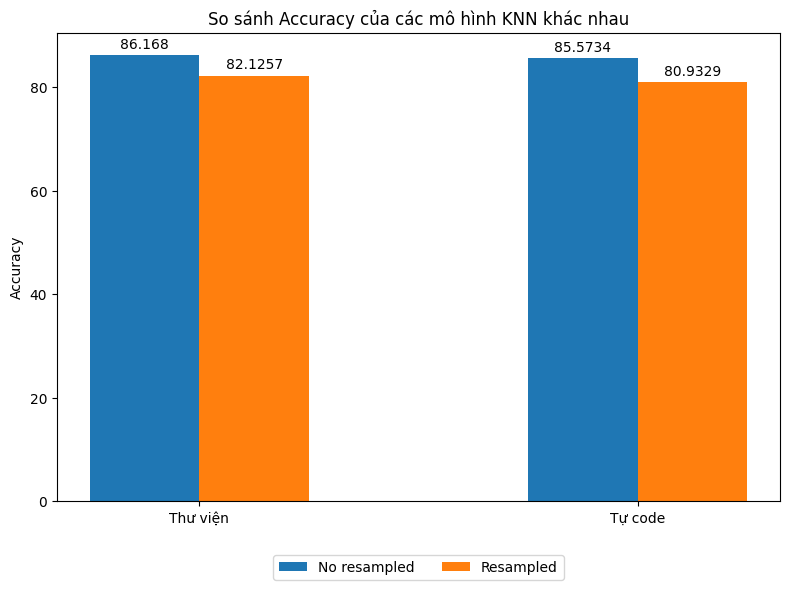

In [ ]:
labels = ['Thư viện', 'Tự code']
no_res = [result_acc[0], result_acc[2]]
res = [result_acc[1], result_acc[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('So sánh Accuracy của các mô hình KNN khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

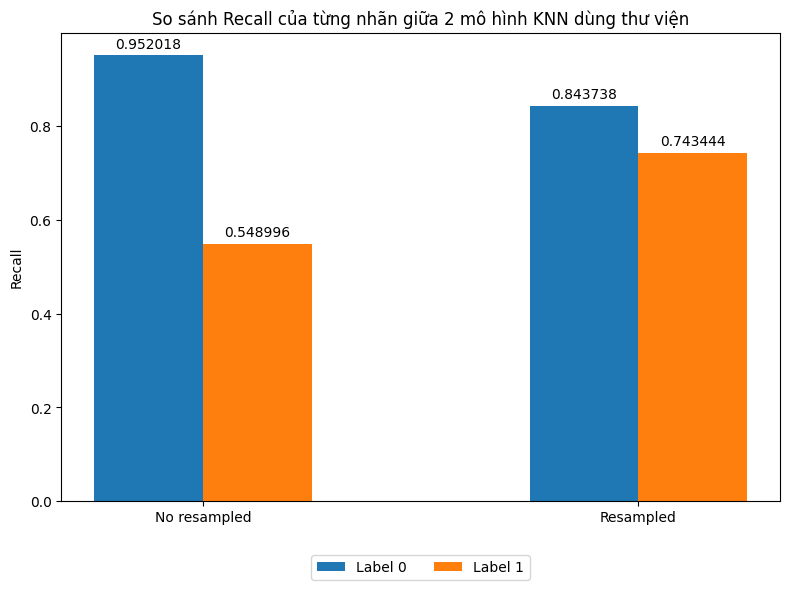

In [ ]:
labels = ['No resampled', 'Resampled']
label_0 = [result_recall[0][0], result_recall[1][0]]
label_1 = [result_recall[0][1], result_recall[1][1]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, label_0, width, label='Label 0')
rects2 = ax.bar(x + width/2, label_1, width, label='Label 1')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Recall')
ax.set_title('So sánh Recall của từng nhãn giữa 2 mô hình KNN dùng thư viện')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

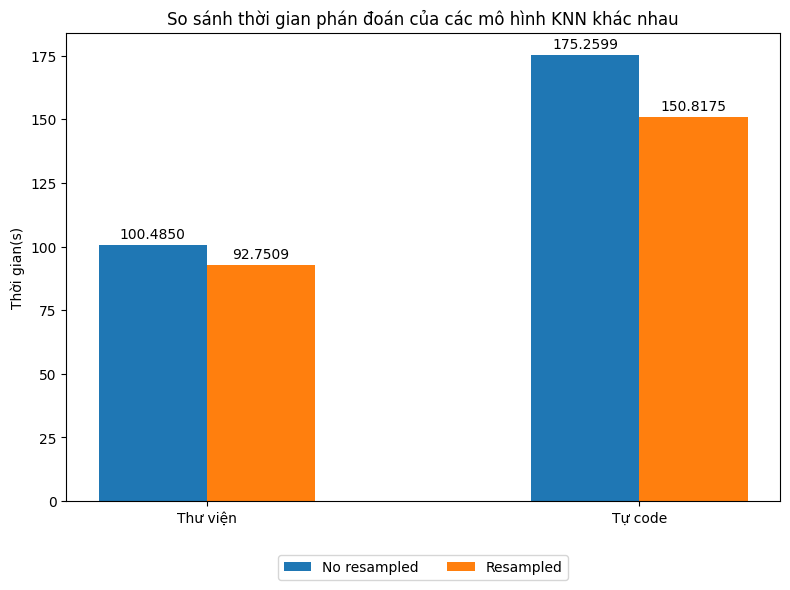

In [ ]:
labels = ['Thư viện', 'Tự code']
no_res = [pred_time[0], pred_time[2]]
res = [pred_time[1], pred_time[3]]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_res, width, label='No resampled')
rects2 = ax.bar(x + width/2, res, width, label='Resampled')

# Add some text for labels, title and custom y-axis tick labels, etc.
ax.set_ylabel('Thời gian(s)')
ax.set_title('So sánh thời gian phán đoán trên tập test của các mô hình KNN khác nhau')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

ax.bar_label(rects1, padding=3, labels=[f"{value:.4f}" for value in no_res])
ax.bar_label(rects2, padding=3, labels=[f"{value:.4f}" for value in res])

fig.tight_layout()

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Result/Model_Evaluation/2. KNN.pkl'
with open(file_path, 'wb') as f:
    pickle.dump([result_acc,result_recall,pred_time],f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
